<a href="https://colab.research.google.com/github/erichsiao1106/RNN/blob/master/lstm_seq2seq_eng2ch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Character-level recurrent sequence-to-sequence model

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2017/09/29<br>
**Last modified:** 2020/04/26<br>
**Description:** Character-level recurrent sequence-to-sequence model.

## Introduction

This example demonstrates how to implement a basic character-level
recurrent sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.

**Summary of the algorithm**

- We start with input sequences from a domain (e.g. English sentences)
    and corresponding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    It uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.


## Setup


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, utils

## Download the data


In [ ]:
!!curl -O http://www.manythings.org/anki/cmn-eng.zip
!!unzip cmn-eng.zip

['Archive:  cmn-eng.zip',
 '  inflating: cmn.txt                 ',
 '  inflating: _about.txt              ']

## Configuration


In [ ]:
batch_size = 64  # Batch size for training.
epochs = 10  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = "cmn.txt"


## Prepare the data


In [ ]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)




Number of samples: 10000
Number of unique input tokens: 72
Number of unique output tokens: 2561
Max sequence length for inputs: 29
Max sequence length for outputs: 22


In [ ]:
# char to token index
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

# One-hot-encoding
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

In [ ]:
decoder_input_data[0], decoder_input_data[0].shape

(array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]], dtype=float32), (22, 2561))

In [ ]:
# Sample decoder input and target data
idx = np.random.randint(0, decoder_input_data.shape[0])
decoder_input = decoder_input_data[idx]
decoder_input = ''.join([target_characters[np.argmax(c)] for c in decoder_input])
decoder_output = decoder_target_data[idx]
decoder_output = ''.join([target_characters[np.argmax(c)] for c in decoder_output])
print('decoder_input :', decoder_input)
print('decoder_output :', decoder_output)
decoder_input, decoder_output

decoder_input : 	那是一個月前了。
            
decoder_output : 那是一個月前了。
             


('\t那是一個月前了。\n            ', '那是一個月前了。\n             ')

In [ ]:
target_token_index

In [ ]:
input_token_index

## Build the model: Seq2Seq


In [ ]:
# Define an input sequence and process it.
encoder_inputs = layers.Input(shape=(None, num_encoder_tokens))
encoder_outputs, state_h, state_c = layers.LSTM(latent_dim, return_state=True)(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = layers.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_outputs, _, _ = layers.LSTM(latent_dim, return_sequences=True, return_state=True)(decoder_inputs, initial_state=encoder_states)
decoder_outputs = layers.Dense(num_decoder_tokens, activation="softmax")(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 72)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 2561)] 0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 336896      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  2885632     input_2[0][0]                    
                                                                 lstm[0][1]                   

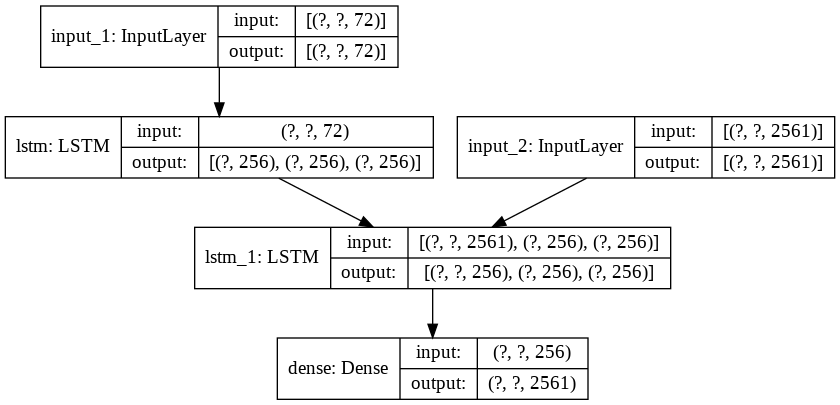

In [ ]:
utils.plot_model(model, show_shapes=True)

## Train the model


In [ ]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)
# Save model
model.save("seq2seq.h5")


Epoch 1/10
125/125 [==============================] - 10s 76ms/step - loss: 2.2841 - accuracy: 0.6397 - val_loss: 2.6246 - val_accuracy: 0.5658
Epoch 2/10
125/125 [==============================] - 8s 63ms/step - loss: 1.9322 - accuracy: 0.6834 - val_loss: 2.4304 - val_accuracy: 0.6337
Epoch 3/10
125/125 [==============================] - 8s 63ms/step - loss: 1.7814 - accuracy: 0.7169 - val_loss: 2.3321 - val_accuracy: 0.6435
Epoch 4/10
125/125 [==============================] - 8s 64ms/step - loss: 1.6786 - accuracy: 0.7313 - val_loss: 2.2316 - val_accuracy: 0.6555
Epoch 5/10
125/125 [==============================] - 8s 63ms/step - loss: 1.6015 - accuracy: 0.7409 - val_loss: 2.1549 - val_accuracy: 0.6675
Epoch 6/10
 70/125 [===============>..............] - ETA: 3s - loss: 1.5415 - accuracy: 0.7492

KeyboardInterrupt: ignored

## Run inference (sampling)

1. encode input and retrieve initial decoder state
2. run one step of decoder with this initial state
and a "start of sequence" token as target.
Output will be the next target token.
3. Repeat with the current target token and current states


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
model = models.load_model("/content/drive/My Drive/class/勞動部/week9/RNN/seq2seq.h5")

# Build encoder
encoder_inputs = model.input[0]  # input_1: encoder input
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1: encoder layer output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = models.Model(encoder_inputs, encoder_states)

# Build Decoder
decoder_inputs = model.input[1]  # input_2: decoder input
decoder_state_input_h = layers.Input(shape=(latent_dim,), name="input_h") # decoder input: h
decoder_state_input_c = layers.Input(shape=(latent_dim,), name="input_c") # decoder input: c
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3] # decoder (last) layer
# decoder initial states are from input(h,c)
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec] # decoder states (h, c) for next timestep
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = models.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to human readable output.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items()) # token index -> char
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())



In [ ]:
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, 72)]        0         
_________________________________________________________________
lstm_2 (LSTM)                [(None, 256), (None, 256) 336896    
Total params: 336,896
Trainable params: 336,896
Non-trainable params: 0
_________________________________________________________________


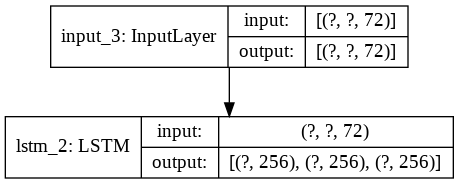

In [ ]:
utils.plot_model(encoder_model, show_shapes=True)

In [ ]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, 2561)] 0                                            
__________________________________________________________________________________________________
input_h (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_c (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, None, 256),  2885632     input_4[0][0]                    
                                                                 input_h[0][0]              

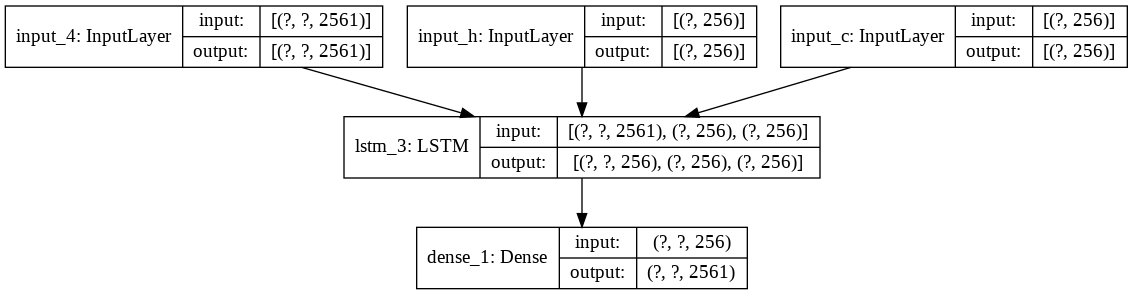

In [ ]:
utils.plot_model(decoder_model, show_shapes=True)

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq) # [encoder h , encoder c]

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0 # <START>

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token by "argmax"
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

You can now generate decoded sentences as such:


In [ ]:
!pip install chinese-converter # convert simplified chinese to traditional

     |████████████████████████████████| 194kB 5.4MB/s 


In [ ]:
import chinese_converter
for seq_index in range(10):
    # Take one sequence (part of the training set) for trying out decoding.
    idx = np.random.randint(0, encoder_input_data.shape[0])
    input_seq = encoder_input_data[idx : idx+1]
    
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input :", input_texts[idx])
    print("Decoded :", chinese_converter.to_traditional(decoded_sentence))


-
Input : Is this your daughter?
Decoded : 這是你的女兒嗎？

-
Input : He is a baseball player.
Decoded : 他是個棒球手。

-
Input : I have a big dog.
Decoded : 我有條大狗。

-
Input : Soccer is my favorite sport.
Decoded : 她明天有三個。

-
Input : He's a good lad.
Decoded : 他是個好人。

-
Input : I wouldn't buy that for Tom.
Decoded : 我會把的別走的回答。

-
Input : Let's not argue.
Decoded : 我們別吵了。

-
Input : I can swim very fast.
Decoded : 我游泳可以遊得很快。

-
Input : What is your date of birth?
Decoded : 你在讀哪本書？

-
Input : I didn't suspect anything.
Decoded : 我沒有懷疑任何事。

